# Denver 2016 Bike Share Multi-Class Classification Modeling

## 1. Introduction

The data exploration performed on the Denver Trips dataset indicates weather variables have a significant impact on the number of checkouts. This section will focus on investigating the use of various classification models on the Trips data when combined with weather variables.

In [1]:
# Import necessary libraries and functions that are needed for the modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn import linear_model, naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score
from sklearn import metrics
import seaborn as sns
from timeit import default_timer as timer
%matplotlib inline

In [2]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
dF = pd.read_csv("data/2016_Denver_Bike_Trip_ML_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [4]:
dF.shape

(402965, 14)

In [5]:
dF.head(1)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance,Checkout_WeekDay,Checkout_Month
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.26,4,1


In [6]:
dF.drop(['User_Program'], axis = 1, inplace = True)
dF.drop(['Membership_Type'], axis = 1, inplace = True)
dF.drop(['User_ID'], axis = 1, inplace = True)
dF.drop(['Bike_Number'], axis = 1, inplace = True)
dF.drop(['Checkout_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Date'], axis = 1, inplace = True)
dF.drop(['Return_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Time'], axis = 1, inplace = True)
dF.drop(['Trip_Duration'], axis = 1, inplace = True)
dF.drop(['Trip_Distance'], axis = 1, inplace = True)

In [7]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Hour       402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Month      402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


In [8]:
# re-arrange columns in preparation for training and test data
dF = dF[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour']]

In [9]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Month      402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Hour       402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


In [10]:
# Load the 2016 Weather data into a dataframe
dW = pd.read_csv("data/Denver_2016_Hourly_Weather_Forecast.csv")

In [11]:
dW.rename(columns = {'Hour': 'Checkout_Hour'}, inplace = True)

In [12]:
dW['Checkout_WeekDay'] = pd.DatetimeIndex(dW['Date']).weekday

In [13]:
dW['Checkout_Month'] = pd.DatetimeIndex(dW['Date']).month

In [14]:
dFW = dF.groupby(['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 
                  'Checkout_Hour']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()

In [15]:
dT = pd.merge(dW, dFW, how='left', left_on=['Date', 'Checkout_Hour'], 
              right_on=['Checkout_Date', 'Checkout_Hour'])

In [16]:
dT.isnull().values.any()

True

In [17]:
nan_rows = dT[dT.isnull().T.any().T]

In [18]:
dT = dT.drop(dT.index[nan_rows.index])

In [19]:
dT.isnull().values.any()

False

In [20]:
dT.drop(['Date', 'Checkout_WeekDay_y', 'Checkout_Month_y'], axis = 1, inplace = True)
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility',
                     'Checkout_WeekDay_x': 'Checkout_WeekDay', 'Checkout_Month_x': 'Checkout_Month'}, inplace = True)

In [21]:
dT = dT[~((dT.Checkout_Hour == 0)  | (dT.Checkout_Hour == 1)  | (dT.Checkout_Hour == 2)  | (dT.Checkout_Hour == 3)  |
         (dT.Checkout_Hour == 4))]

In [22]:
dT.shape

(6849, 11)

In [23]:
dT['Number_Of_Checkouts'].max()

252.0

In [24]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6849 entries, 8 to 8783
Data columns (total 11 columns):
Checkout_Hour           6849 non-null int64
Apparent_Temperature    6849 non-null float64
Cloud_Cover             6849 non-null float64
Humidity                6849 non-null float64
Temperature             6849 non-null float64
Visibility              6849 non-null float64
Wind_Speed              6849 non-null float64
Checkout_WeekDay        6849 non-null int32
Checkout_Month          6849 non-null int32
Checkout_Date           6849 non-null object
Number_Of_Checkouts     6849 non-null float64
dtypes: float64(7), int32(2), int64(1), object(1)
memory usage: 588.6+ KB


In [26]:
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [27]:
dT = dT[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Humidity', 'Wind_Speed', 'Visibility', 'Number_Of_Checkouts']]

### Convert the numeric Calendar and Clock columns into categorical columns

In [28]:
month_dummies = pd.get_dummies(dT.Checkout_Month, prefix='month')

In [29]:
weekday_dummies = pd.get_dummies(dT.Checkout_WeekDay, prefix='weekday')

In [30]:
hour_dummies = pd.get_dummies(dT.Checkout_Hour, prefix='hour')

In [31]:
data = pd.concat([dT, month_dummies, weekday_dummies, hour_dummies], axis=1)

In [32]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Number_Of_Checkouts']]

In [33]:
data['Number_Of_Checkouts'] = data[['Number_Of_Checkouts']].astype('int32')

### Create a Class_Label column for a 4-class classification 

In [34]:
data['Class_Label'] = data['Number_Of_Checkouts'].map(lambda x: 0 if ((x >= 1) & (x <= 50)) 
                                                else 1 if ((x >= 51)  & (x <= 100)) 
                                                else 2 if ((x >= 101)  & (x <= 150)) 
                                                else 3)

In [35]:
data.head()

,Checkout_Month,Checkout_WeekDay,Checkout_Hour,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,hour_22,hour_23,Temperature,Apparent_Temperature,Cloud_Cover,Wind_Speed,Humidity,Visibility,Number_Of_Checkouts,Class_Label
8,1,4,8,1,0,0,0,0,0,0,...,0,0,6.63,-5.68,0.00,7.61,0.73,10.00,3,0
9,1,4,9,1,0,0,0,0,0,0,...,0,0,13.85,4.28,0.08,6.33,0.64,10.00,8,0
10,1,4,10,1,0,0,0,0,0,0,...,0,0,19.73,9.49,0.16,8.55,0.54,10.00,7,0
11,1,4,11,1,0,0,0,0,0,0,...,0,0,25.91,19.04,0.16,5.93,0.42,10.00,22,0
12,1,4,12,1,0,0,0,0,0,0,...,0,0,29.53,23.17,0.16,6.15,0.37,9.97,13,0


### Keep 10 samples aside for use in prediction on unseen samples

In [36]:
dUT = data.sample(n=10, random_state=123)

In [37]:
del_rows = dUT.index

In [38]:
data.drop(del_rows, axis=0, inplace=True)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6839 entries, 8 to 8783
Data columns (total 49 columns):
Checkout_Month          6839 non-null int32
Checkout_WeekDay        6839 non-null int32
Checkout_Hour           6839 non-null int64
month_1                 6839 non-null uint8
month_2                 6839 non-null uint8
month_3                 6839 non-null uint8
month_4                 6839 non-null uint8
month_5                 6839 non-null uint8
month_6                 6839 non-null uint8
month_7                 6839 non-null uint8
month_8                 6839 non-null uint8
month_9                 6839 non-null uint8
month_10                6839 non-null uint8
month_11                6839 non-null uint8
month_12                6839 non-null uint8
weekday_0               6839 non-null uint8
weekday_1               6839 non-null uint8
weekday_2               6839 non-null uint8
weekday_3               6839 non-null uint8
weekday_4               6839 non-null uint8
weekday_5    

In [40]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Class_Label']]

In [42]:
array = data.values

In [43]:
X = array[:,3:47]
X[0]

array([  1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   6.63,  -5.68,
         0.  ,   7.61,   0.73,  10.  ])

In [44]:
y = array[:,47]
y[0]

0.0

## Feature Correlations

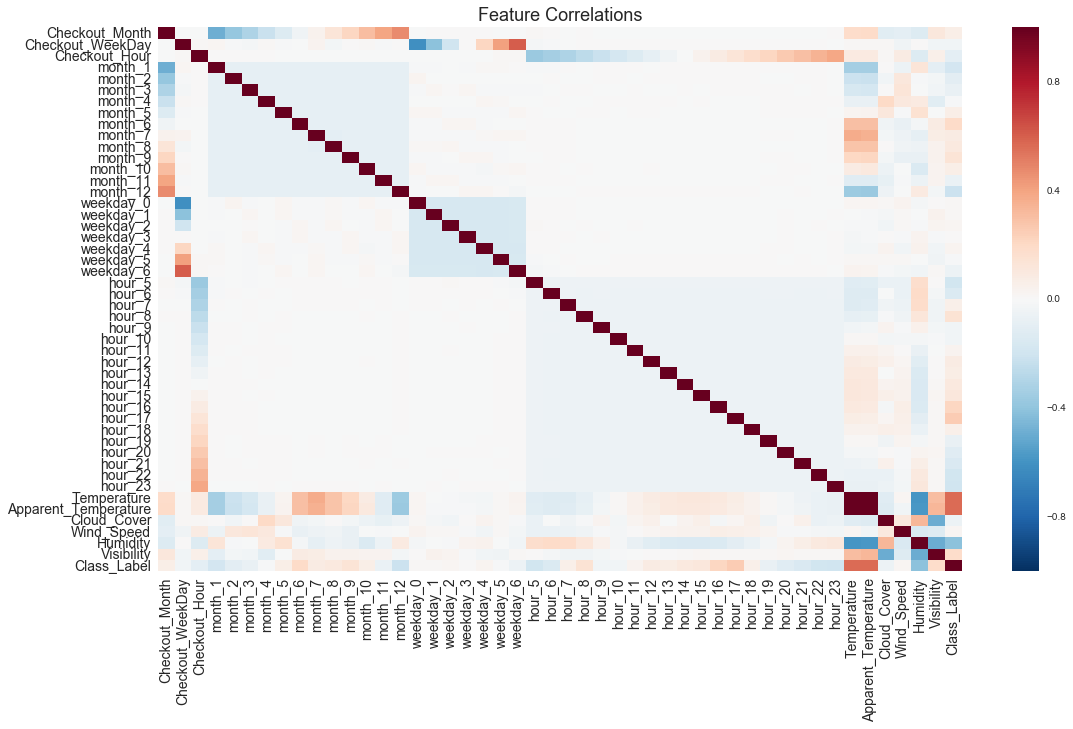

In [45]:
plt.figure(figsize=(18,10))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [46]:
features = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Class_Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## 2. Modeling - Categorical Feature Set

In [47]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,14))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

In [48]:
def get_class_metrics(model, actual, predicted):
    class_metrics = {'Accuracy' : metrics.accuracy_score(actual, predicted),
                         'F1 (macro)' : metrics.f1_score(actual, predicted, average='macro'),
                         'F1 (micro)' : metrics.f1_score(actual, predicted, average='micro'),
                         'Precision (macro)' : metrics.precision_score(actual, predicted,  average='macro'),
                         'Precision (micro)' : metrics.precision_score(actual, predicted,  average='micro'),
                         'Recall (macro)' : metrics.recall_score(actual, predicted,  average='macro'),
                         'Recall (micro)' : metrics.recall_score(actual, predicted,  average='micro')}
    dML_metrics = pd.DataFrame.from_dict(class_metrics, orient='index')
    dML_metrics.columns = [model]
    return dML_metrics

In [49]:
def perform_classification(model, clfr):   
 
    clfr.fit(X_train, y_train)
    ypred = clfr.predict(X_test)
    got_metrics = get_class_metrics(model, y_test, ypred)
    print(model,'\n')
    print("Accuracy on training set: {:.3f}".format(clfr.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(clfr.score(X_test, y_test)))
    print('\nConfusion Matrix:')
    print(metrics.confusion_matrix(y_test, ypred))
    print('\nClassification Report:')
    print(metrics.classification_report(y_test, ypred))
    return got_metrics

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit
def perform_cross_validation(model, clfr):
    shuffle_split = StratifiedShuffleSplit(test_size=.5, train_size=.5, n_splits=5)
    scores = cross_val_score(clfr, X, y, cv=shuffle_split)
    print("Cross-validation scores:\n{}".format(scores))
    print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2) + " @ 95% CI")
    #print("Cross-validation scores mean: {:.3f}".format(scores.mean()))
    xv_metrics = {'Cross Validation' : scores.mean()}
    dXV_metrics = pd.DataFrame.from_dict(xv_metrics, orient='index')
    dXV_metrics.columns = [model]
    return dXV_metrics

In [51]:
def get_execution_time_metrics(model, et):
    et_metrics = {'Execution Time (sec)' : et}
    dET_metrics = pd.DataFrame.from_dict(et_metrics, orient='index')
    dET_metrics.columns = [model]
    return dET_metrics

#### Decision Tree Classification

Decision Tree Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.730

Confusion Matrix:
[[880 124  15   0]
 [130 422  99  12]
 [  8  98 146  33]
 [  2   4  29  50]]

Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.86      0.86      1019
          1       0.65      0.64      0.64       663
          2       0.51      0.51      0.51       285
          3       0.53      0.59      0.56        85

avg / total       0.73      0.73      0.73      2052

Cross-validation scores:
[ 0.72222222  0.70994152  0.72105263  0.71666667  0.71461988]
Cross-validation accuracy: 0.72 (+/- 0.01) @ 95% CI

Execution Time (sec): 0.305


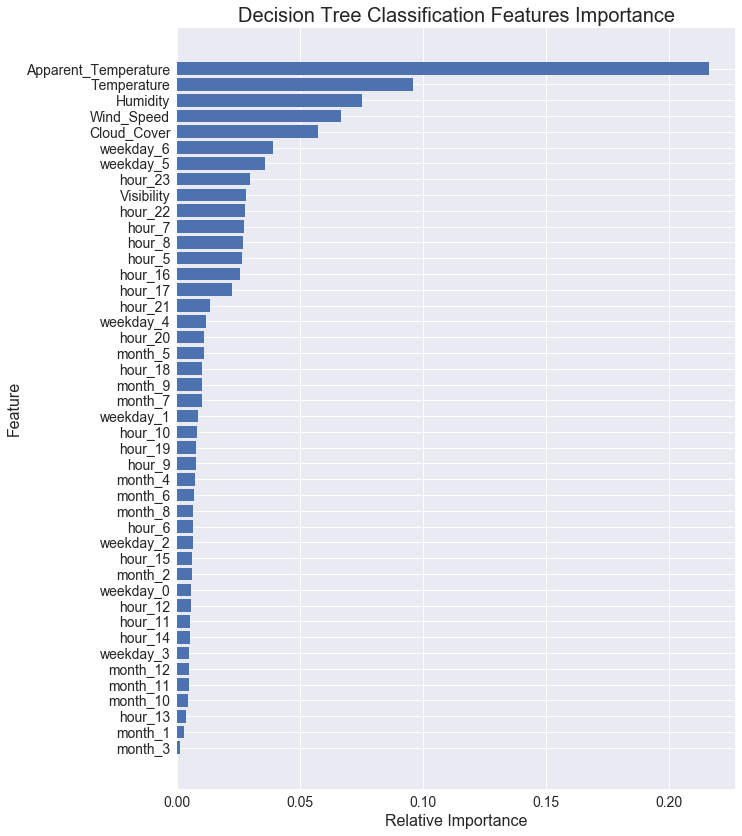

,Decision Tree Classification
Accuracy,0.730019
F1 (macro),0.642804
F1 (micro),0.730019
Precision (macro),0.636371
Precision (micro),0.730019
Recall (macro),0.650152
Recall (micro),0.730019


In [52]:
# Decision Tree Classifier
class_model = 'Decision Tree Classification'
start = timer()
clf = DecisionTreeClassifier(random_state=0)
dtc = perform_classification(class_model, clf)
dtc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format(et))
dtc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
dtc.sort_index()

#### Linear (Logistic) Classification

In [53]:
# logistic regression
class_model = 'Logistic Classification'
start = timer()
#clf = linear_model.LogisticRegression(random_state=0)
clf = linear_model.LogisticRegression(C=1.0, solver='lbfgs', random_state=0, multi_class='ovr', n_jobs=-1)
lin_reg = perform_classification(class_model, clf)
lin_reg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
lin_reg_et = get_execution_time_metrics(class_model, et)
lin_reg.sort_index()

Logistic Classification 

Accuracy on training set: 0.731
Accuracy on test set: 0.728

Confusion Matrix:
[[901  91  26   1]
 [156 479  20   8]
 [ 18 159  96  12]
 [  0  39  28  18]]

Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.88      0.86      1019
          1       0.62      0.72      0.67       663
          2       0.56      0.34      0.42       285
          3       0.46      0.21      0.29        85

avg / total       0.72      0.73      0.71      2052

Cross-validation scores:
[ 0.72602339  0.72660819  0.71929825  0.72368421  0.72222222]
Cross-validation accuracy: 0.72 (+/- 0.01) @ 95% CI

Execution Time (sec): 14.113


,Logistic Classification
Accuracy,0.728070
F1 (macro),0.560579
F1 (micro),0.728070
Precision (macro),0.622020
Precision (micro),0.728070
Recall (macro),0.538820
Recall (micro),0.728070


#### Random Forest Classification

Random Forest Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.786

Confusion Matrix:
[[924  90   5   0]
 [111 514  35   3]
 [  9 117 140  19]
 [  2   9  39  35]]

Classification Report:
             precision    recall  f1-score   support

          0       0.88      0.91      0.89      1019
          1       0.70      0.78      0.74       663
          2       0.64      0.49      0.56       285
          3       0.61      0.41      0.49        85

avg / total       0.78      0.79      0.78      2052

Cross-validation scores:
[ 0.77690058  0.78391813  0.78040936  0.78421053  0.7874269 ]
Cross-validation accuracy: 0.78 (+/- 0.01) @ 95% CI

Execution Time (sec): 3.769


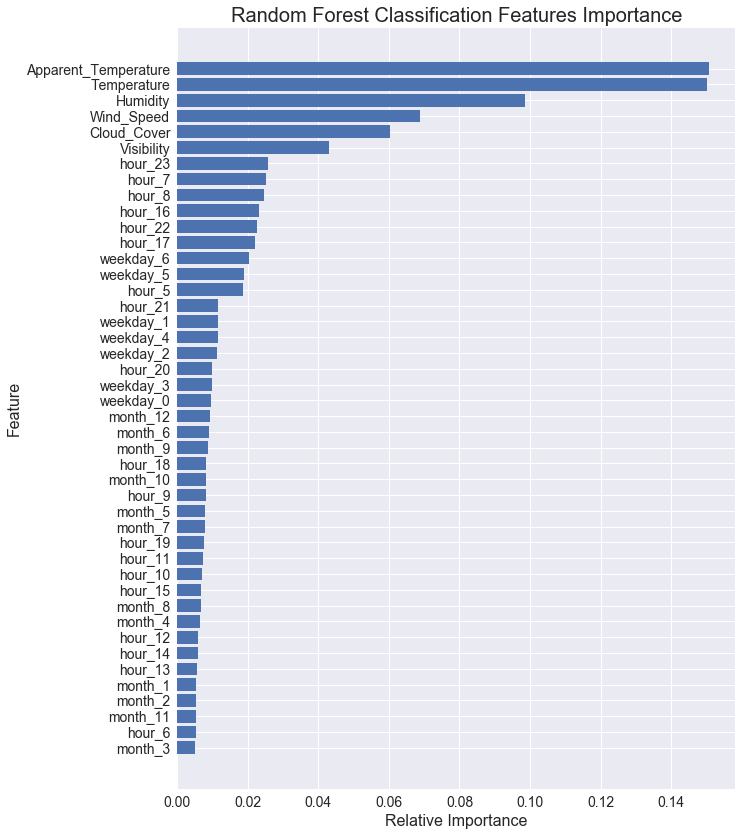

,Random Forest Classification
Accuracy,0.786062
F1 (macro),0.670351
F1 (micro),0.786062
Precision (macro),0.710195
Precision (micro),0.786062
Recall (macro),0.646257
Recall (micro),0.786062


In [54]:
# Random Forest Classifier
class_model = 'Random Forest Classification'
start = timer() 
clf = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
rfc = perform_classification(class_model, clf)
rfc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
rfc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
rfc.sort_index()

#### Extra Trees Classification

Extra Trees Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.806

Confusion Matrix:
[[933  83   3   0]
 [ 83 523  54   3]
 [  5  96 152  32]
 [  0   3  36  46]]

Classification Report:
             precision    recall  f1-score   support

          0       0.91      0.92      0.91      1019
          1       0.74      0.79      0.76       663
          2       0.62      0.53      0.57       285
          3       0.57      0.54      0.55        85

avg / total       0.80      0.81      0.80      2052

Cross-validation scores:
[ 0.80614035  0.79298246  0.80643275  0.79795322  0.79853801]
Cross-validation accuracy: 0.80 (+/- 0.01) @ 95% CI

Execution Time (sec): 3.374


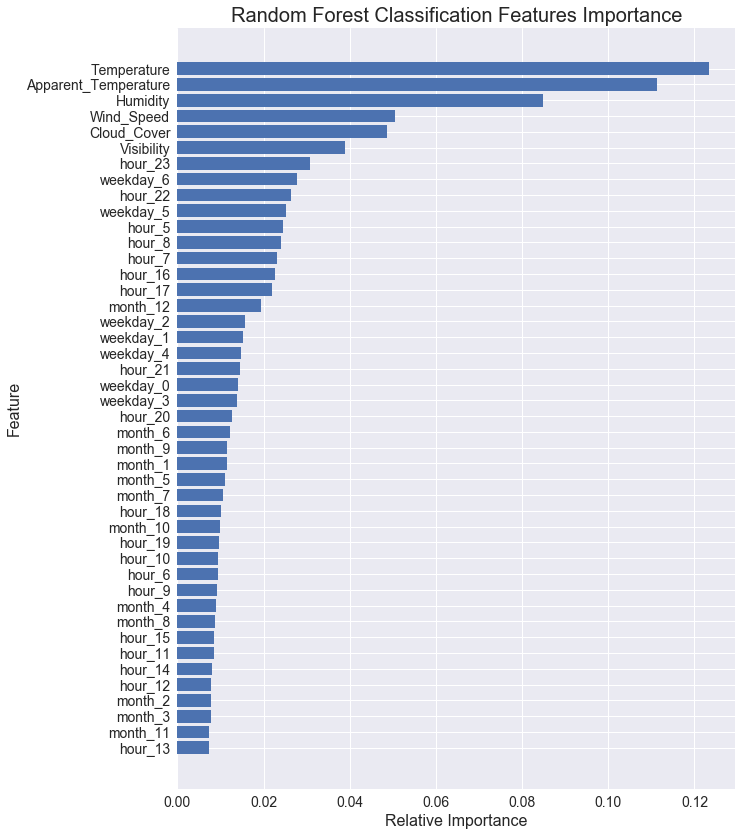

,Extra Trees Classification
Accuracy,0.806043
F1 (macro),0.701782
F1 (micro),0.806043
Precision (macro),0.710991
Precision (micro),0.806043
Recall (macro),0.694738
Recall (micro),0.806043


In [55]:
# Extra Trees Classifier
class_model = 'Extra Trees Classification'
start = timer() 
clf = ExtraTreesClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
etc = perform_classification(class_model, clf)
etc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
etc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, 'Random Forest Classification')
etc.sort_index()

#### Naive Bayes Classification

In [56]:
# Naive Bayes Classifier
class_model = 'Naive Bayes Classification'
start = timer()
clf = naive_bayes.GaussianNB()
nbg = perform_classification(class_model, clf)
nbg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
nbg_et = get_execution_time_metrics(class_model, et)
nbg.sort_index()

Naive Bayes Classification 

Accuracy on training set: 0.456
Accuracy on test set: 0.457

Confusion Matrix:
[[547 330  45  97]
 [ 18 271  67 307]
 [  2  18  36 229]
 [  1   0   0  84]]

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.54      0.69      1019
          1       0.44      0.41      0.42       663
          2       0.24      0.13      0.17       285
          3       0.12      0.99      0.21        85

avg / total       0.66      0.46      0.51      2052

Cross-validation scores:
[ 0.46374269  0.44035088  0.4371345   0.46374269  0.44298246]
Cross-validation accuracy: 0.45 (+/- 0.02) @ 95% CI

Execution Time (sec): 0.182


,Naive Bayes Classification
Accuracy,0.457115
F1 (macro),0.371971
F1 (micro),0.457115
Precision (macro),0.440307
Precision (micro),0.457115
Recall (macro),0.515025
Recall (micro),0.457115


#### Nearest Neighbors Classification

In [57]:
# Nearest Neighbors Classifier
class_model = 'Nearest Neighbors Classification'
start = timer()
clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knn = perform_classification(class_model, clf)
knn_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
knn_et = get_execution_time_metrics(class_model, et)
knn.sort_index()

Nearest Neighbors Classification 

Accuracy on training set: 0.798
Accuracy on test set: 0.640

Confusion Matrix:
[[915  97   7   0]
 [274 337  50   2]
 [ 70 153  58   4]
 [ 16  36  30   3]]

Classification Report:
             precision    recall  f1-score   support

          0       0.72      0.90      0.80      1019
          1       0.54      0.51      0.52       663
          2       0.40      0.20      0.27       285
          3       0.33      0.04      0.06        85

avg / total       0.60      0.64      0.61      2052

Cross-validation scores:
[ 0.62076023  0.62777778  0.62719298  0.62280702  0.62602339]
Cross-validation accuracy: 0.62 (+/- 0.01) @ 95% CI

Execution Time (sec): 0.977


,Nearest Neighbors Classification
Accuracy,0.639864
F1 (macro),0.413859
F1 (micro),0.639864
Precision (macro),0.497978
Precision (micro),0.639864
Recall (macro),0.411259
Recall (micro),0.639864


#### Gradient Boosting Classification

Gradient Boosting Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.756

Confusion Matrix:
[[901 113   5   0]
 [116 480  63   4]
 [ 20 114 133  18]
 [  2   7  38  38]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.88      0.88      1019
          1       0.67      0.72      0.70       663
          2       0.56      0.47      0.51       285
          3       0.63      0.45      0.52        85

avg / total       0.75      0.76      0.75      2052

Cross-validation scores:
[ 0.76081871  0.74385965  0.73391813  0.75263158  0.74649123]
Cross-validation accuracy: 0.75 (+/- 0.02) @ 95% CI

Execution Time (sec): 109.658


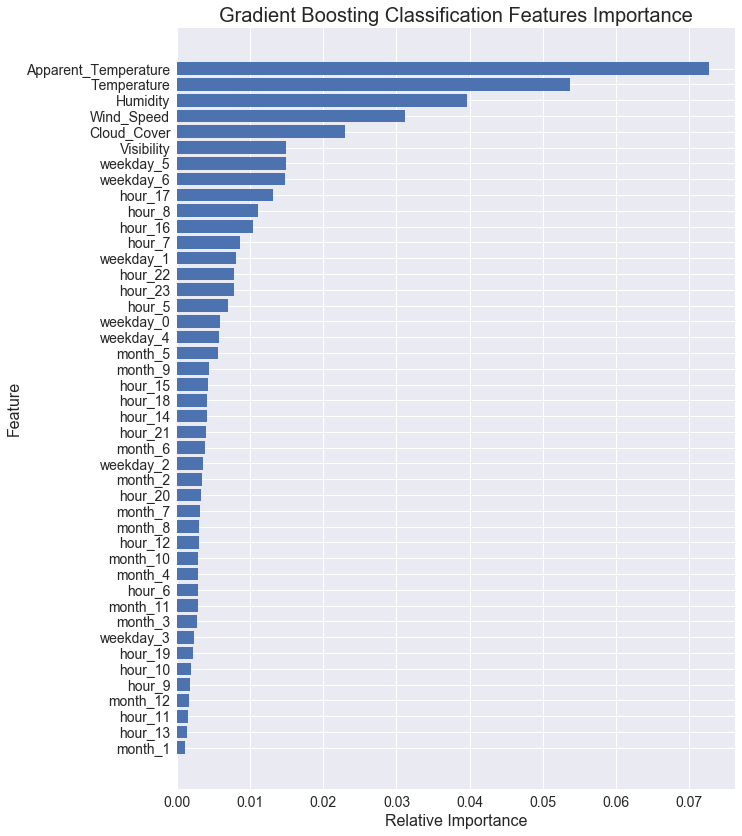

,Gradient Boosting Classification
Accuracy,0.756335
F1 (macro),0.651137
F1 (micro),0.756335
Precision (macro),0.682317
Precision (micro),0.756335
Recall (macro),0.630477
Recall (micro),0.756335


In [58]:
# Gradient Boosting Classifier
class_model = 'Gradient Boosting Classification'
#clf = GradientBoostingClassifier()
start = timer()
clf = GradientBoostingClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0)
gbc = perform_classification(class_model, clf)
gbc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
gbc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
gbc.sort_index()

#### Multi-layer Perceptron Classification

In [59]:
# Multi-Layer Perceptron Classification
class_model = 'Multi-Layer Perception Classification'
start = timer()
clf = MLPClassifier(random_state=0)
mlp = perform_classification(class_model, clf)
mlp_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
mlp_et = get_execution_time_metrics(class_model, et)
mlp.sort_index()

Multi-Layer Perception Classification 

Accuracy on training set: 0.804
Accuracy on test set: 0.791

Confusion Matrix:
[[917  96   4   2]
 [ 78 535  44   6]
 [  2 118 154  11]
 [  0  11  56  18]]

Classification Report:
             precision    recall  f1-score   support

          0       0.92      0.90      0.91      1019
          1       0.70      0.81      0.75       663
          2       0.60      0.54      0.57       285
          3       0.49      0.21      0.30        85

avg / total       0.79      0.79      0.79      2052

Cross-validation scores:
[ 0.75877193  0.75789474  0.74327485  0.77397661  0.72836257]
Cross-validation accuracy: 0.75 (+/- 0.03) @ 95% CI

Execution Time (sec): 8.583


,Multi-Layer Perception Classification
Accuracy,0.791423
F1 (macro),0.630989
F1 (micro),0.791423
Precision (macro),0.676773
Precision (micro),0.791423
Recall (macro),0.614739
Recall (micro),0.791423


## Classification Summary with Categorical Feature Set

In [60]:
class_metrics = pd.concat([lin_reg, dtc, rfc, etc, nbg, knn, gbc, mlp] , axis=1)

In [61]:
xv_metrics = pd.concat([lin_reg_xv, dtc_xv, rfc_xv, etc_xv, nbg_xv, knn_xv, gbc_xv, mlp_xv], axis = 1)

In [62]:
et_metrics = pd.concat([lin_reg_et, dtc_et, rfc_et, etc_et, nbg_et, knn_et, gbc_et, mlp_et], axis = 1)

In [63]:
final_metrics = pd.concat([class_metrics, xv_metrics, et_metrics])
print("Classification Summary with Categorical Features\n")
final_metrics

Classification Summary with Categorical Features



,Logistic Classification,Decision Tree Classification,Random Forest Classification,Extra Trees Classification,Naive Bayes Classification,Nearest Neighbors Classification,Gradient Boosting Classification,Multi-Layer Perception Classification
Accuracy,0.728070,0.730019,0.786062,0.806043,0.457115,0.639864,0.756335,0.791423
F1 (macro),0.560579,0.642804,0.670351,0.701782,0.371971,0.413859,0.651137,0.630989
F1 (micro),0.728070,0.730019,0.786062,0.806043,0.457115,0.639864,0.756335,0.791423
Precision (macro),0.622020,0.636371,0.710195,0.710991,0.440307,0.497978,0.682317,0.676773
Precision (micro),0.728070,0.730019,0.786062,0.806043,0.457115,0.639864,0.756335,0.791423
Recall (macro),0.538820,0.650152,0.646257,0.694738,0.515025,0.411259,0.630477,0.614739
Recall (micro),0.728070,0.730019,0.786062,0.806043,0.457115,0.639864,0.756335,0.791423
Cross Validation,0.723567,0.716901,0.782573,0.800409,0.449591,0.624912,0.747544,0.752456
Execution Time (sec),14.112561,0.305439,3.768788,3.373617,0.181900,0.976621,109.657515,8.583196


The Extra Trees model attained the highest accuracy in classifying the four classes. The Naïve Bayes model performed the poorest.

## 3. Modeling - Numerical Feature Set

In [64]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 
           'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Class_Label']]

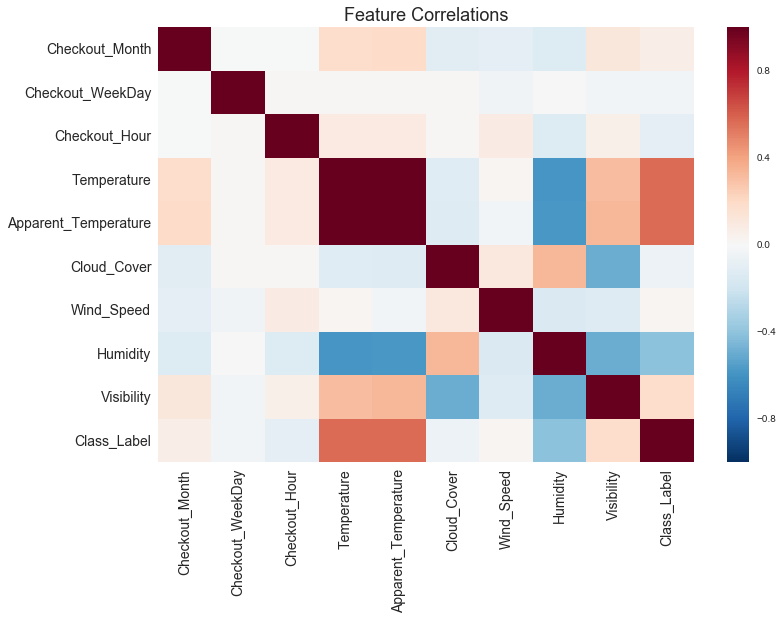

In [65]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6839 entries, 8 to 8783
Data columns (total 10 columns):
Checkout_Month          6839 non-null int32
Checkout_WeekDay        6839 non-null int32
Checkout_Hour           6839 non-null int64
Temperature             6839 non-null float64
Apparent_Temperature    6839 non-null float64
Cloud_Cover             6839 non-null float64
Wind_Speed              6839 non-null float64
Humidity                6839 non-null float64
Visibility              6839 non-null float64
Class_Label             6839 non-null int64
dtypes: float64(6), int32(2), int64(2)
memory usage: 534.3 KB


In [67]:
array = data.values
X = array[:,0:8]
y = array[:,8]

In [68]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Class_Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [69]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,6))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

#### Decision Tree Classification

Decision Tree Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.732

Confusion Matrix:
[[883 125  11   0]
 [128 429 100   6]
 [  5  90 149  41]
 [  0   7  36  42]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.87      0.87      1019
          1       0.66      0.65      0.65       663
          2       0.50      0.52      0.51       285
          3       0.47      0.49      0.48        85

avg / total       0.73      0.73      0.73      2052

Cross-validation scores:
[ 0.72163743  0.73567251  0.73830409  0.73070175  0.73567251]
Cross-validation accuracy: 0.73 (+/- 0.01) @ 95% CI

Execution Time (sec): 0.191


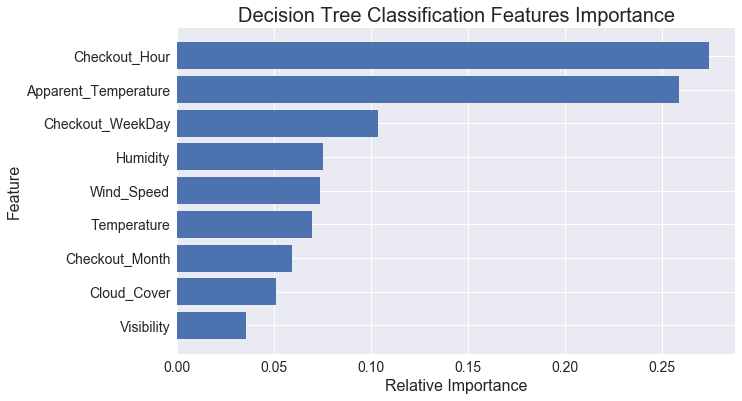

,Decision Tree Classification
Accuracy,0.732456
F1 (macro),0.629112
F1 (micro),0.732456
Precision (macro),0.625842
Precision (micro),0.732456
Recall (macro),0.632630
Recall (micro),0.732456


In [70]:
# Decision Tree Classifier
class_model = 'Decision Tree Classification'
start = timer()
clf = DecisionTreeClassifier(random_state=0)
dtc = perform_classification(class_model, clf)
dtc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format(et))
dtc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
dtc.sort_index()

#### Linear (Logistic Regression) Classification

In [71]:
# logistic regression
class_model = 'Logistic Classification'
start = timer()
#clf = linear_model.LogisticRegression(random_state=0)
clf = linear_model.LogisticRegression(C=1.0, solver='lbfgs', random_state=0, multi_class='ovr', n_jobs=-1)
lin_reg = perform_classification(class_model, clf)
lin_reg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
lin_reg_et = get_execution_time_metrics(class_model, et)
lin_reg.sort_index()

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic Classification 

Accuracy on training set: 0.644
Accuracy on test set: 0.640

Confusion Matrix:
[[875 144   0   0]
 [224 439   0   0]
 [ 56 229   0   0]
 [  4  81   0   0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.75      0.86      0.80      1019
          1       0.49      0.66      0.56       663
          2       0.00      0.00      0.00       285
          3       0.00      0.00      0.00        85

avg / total       0.53      0.64      0.58      2052

Cross-validation scores:
[ 0.64532164  0.6377193   0.64005848  0.63976608  0.64736842]
Cross-validation accuracy: 0.64 (+/- 0.01) @ 95% CI

Execution Time (sec): 12.177


,Logistic Classification
Accuracy,0.640351
F1 (macro),0.341939
F1 (micro),0.640351
Precision (macro),0.311641
Precision (micro),0.640351
Recall (macro),0.380207
Recall (micro),0.640351


#### Random Forest Classification

Random Forest Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.793

Confusion Matrix:
[[926  92   1   0]
 [104 520  38   1]
 [  4 117 151  13]
 [  1   7  46  31]]

Classification Report:
             precision    recall  f1-score   support

          0       0.89      0.91      0.90      1019
          1       0.71      0.78      0.74       663
          2       0.64      0.53      0.58       285
          3       0.69      0.36      0.48        85

avg / total       0.79      0.79      0.79      2052

Cross-validation scores:
[ 0.79210526  0.78421053  0.79093567  0.78830409  0.78976608]
Cross-validation accuracy: 0.79 (+/- 0.01) @ 95% CI

Execution Time (sec): 3.941


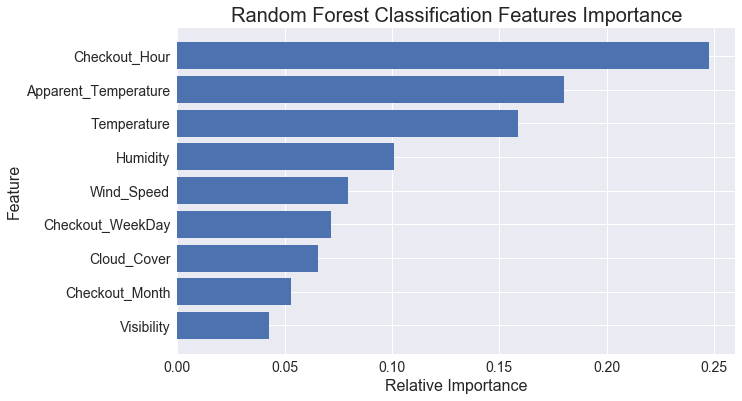

,Random Forest Classification
Accuracy,0.793372
F1 (macro),0.675405
F1 (micro),0.793372
Precision (macro),0.732482
Precision (micro),0.793372
Recall (macro),0.646895
Recall (micro),0.793372


In [72]:
# Random Forest Classifier
class_model = 'Random Forest Classification'
start = timer() 
clf = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
rfc = perform_classification(class_model, clf)
rfc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
rfc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
rfc.sort_index()

#### Extra Trees Classification

Extra Trees Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.792

Confusion Matrix:
[[935  82   2   0]
 [115 506  41   1]
 [ 14 107 147  17]
 [  1   7  40  37]]

Classification Report:
             precision    recall  f1-score   support

          0       0.88      0.92      0.90      1019
          1       0.72      0.76      0.74       663
          2       0.64      0.52      0.57       285
          3       0.67      0.44      0.53        85

avg / total       0.79      0.79      0.79      2052

Cross-validation scores:
[ 0.77894737  0.78625731  0.78450292  0.77426901  0.77777778]
Cross-validation accuracy: 0.78 (+/- 0.01) @ 95% CI

Execution Time (sec): 3.225


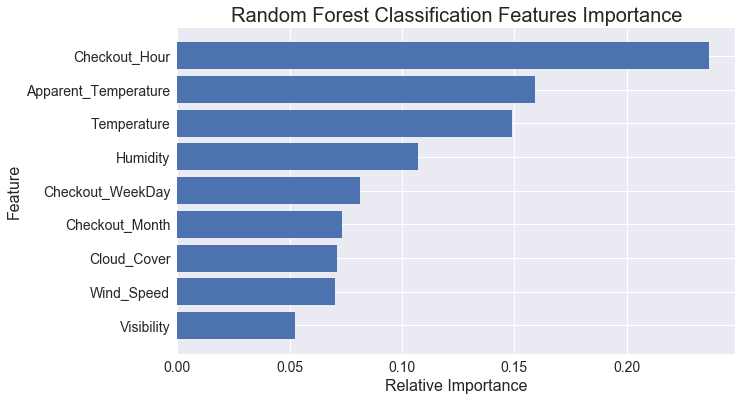

,Extra Trees Classification
Accuracy,0.791910
F1 (macro),0.684538
F1 (micro),0.791910
Precision (macro),0.727647
Precision (micro),0.791910
Recall (macro),0.657962
Recall (micro),0.791910


In [73]:
# Extra Trees Classifier
class_model = 'Extra Trees Classification'
start = timer() 
clf = ExtraTreesClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
etc = perform_classification(class_model, clf)
etc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
etc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, 'Random Forest Classification')
etc.sort_index()

#### Naive Bayes Classification

In [74]:
# Naive Bayes Classifier
class_model = 'Naive Bayes Classification'
start = timer()
clf = naive_bayes.GaussianNB()
nbg = perform_classification(class_model, clf)
nbg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
nbg_et = get_execution_time_metrics(class_model, et)
nbg.sort_index()

Naive Bayes Classification 

Accuracy on training set: 0.529
Accuracy on test set: 0.504

Confusion Matrix:
[[676 224 112   7]
 [116 188 311  48]
 [ 25  78 159  23]
 [  1  12  60  12]]

Classification Report:
             precision    recall  f1-score   support

          0       0.83      0.66      0.74      1019
          1       0.37      0.28      0.32       663
          2       0.25      0.56      0.34       285
          3       0.13      0.14      0.14        85

avg / total       0.57      0.50      0.52      2052

Cross-validation scores:
[ 0.51374269  0.54444444  0.48976608  0.52660819  0.54590643]
Cross-validation accuracy: 0.52 (+/- 0.04) @ 95% CI

Execution Time (sec): 0.099


,Naive Bayes Classification
Accuracy,0.504386
F1 (macro),0.384729
F1 (micro),0.504386
Precision (macro),0.395476
Precision (micro),0.504386
Recall (macro),0.411507
Recall (micro),0.504386


#### Nearest Neighbors Classification

In [75]:
# Nearest Neighbors Classifier
class_model = 'Nearest Neighbors Classification'
start = timer()
clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knn = perform_classification(class_model, clf)
knn_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
knn_et = get_execution_time_metrics(class_model, et)
knn.sort_index()

Nearest Neighbors Classification 

Accuracy on training set: 0.838
Accuracy on test set: 0.688

Confusion Matrix:
[[935  78   6   0]
 [228 391  43   1]
 [ 33 164  83   5]
 [  5  34  43   3]]

Classification Report:
             precision    recall  f1-score   support

          0       0.78      0.92      0.84      1019
          1       0.59      0.59      0.59       663
          2       0.47      0.29      0.36       285
          3       0.33      0.04      0.06        85

avg / total       0.66      0.69      0.66      2052

Cross-validation scores:
[ 0.68421053  0.67368421  0.69444444  0.68625731  0.6877193 ]
Cross-validation accuracy: 0.69 (+/- 0.01) @ 95% CI

Execution Time (sec): 0.934


,Nearest Neighbors Classification
Accuracy,0.688109
F1 (macro),0.463753
F1 (micro),0.688109
Precision (macro),0.543086
Precision (micro),0.688109
Recall (macro),0.458458
Recall (micro),0.688109


#### Gradient Boosting Classification

Gradient Boosting Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.760

Confusion Matrix:
[[911 104   3   1]
 [118 471  70   4]
 [ 12 102 138  33]
 [  1   7  37  40]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.89      0.88      1019
          1       0.69      0.71      0.70       663
          2       0.56      0.48      0.52       285
          3       0.51      0.47      0.49        85

avg / total       0.76      0.76      0.76      2052

Cross-validation scores:
[ 0.75409357  0.7619883   0.76842105  0.76666667  0.75906433]
Cross-validation accuracy: 0.76 (+/- 0.01) @ 95% CI

Execution Time (sec): 60.607


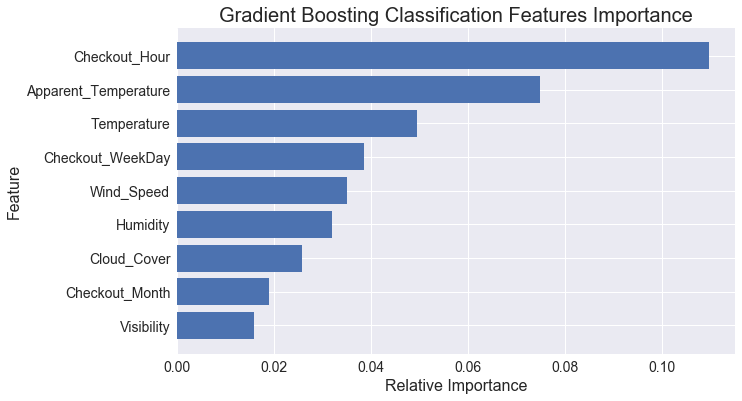

,Gradient Boosting Classification
Accuracy,0.760234
F1 (macro),0.647997
F1 (micro),0.760234
Precision (macro),0.658037
Precision (micro),0.760234
Recall (macro),0.639805
Recall (micro),0.760234


In [76]:
# Gradient Boosting Classifier
class_model = 'Gradient Boosting Classification'
#clf = GradientBoostingClassifier()
start = timer()
clf = GradientBoostingClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0)
gbc = perform_classification(class_model, clf)
gbc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
gbc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
gbc.sort_index()

#### Multi-layer Perceptron Classification

In [77]:
# Multi-Layer Perceptron Classification
class_model = 'Multi-Layer Perception Classification'
start = timer()
clf = MLPClassifier(random_state=0)
mlp = perform_classification(class_model, clf)
mlp_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
mlp_et = get_execution_time_metrics(class_model, et)
mlp.sort_index()

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Multi-Layer Perception Classification 

Accuracy on training set: 0.689
Accuracy on test set: 0.687

Confusion Matrix:
[[873 142   4   0]
 [144 478  41   0]
 [ 24 202  59   0]
 [  0  57  28   0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.86      0.85      1019
          1       0.54      0.72      0.62       663
          2       0.45      0.21      0.28       285
          3       0.00      0.00      0.00        85

avg / total       0.65      0.69      0.66      2052

Cross-validation scores:
[ 0.67660819  0.66432749  0.68128655  0.66461988  0.63538012]
Cross-validation accuracy: 0.66 (+/- 0.03) @ 95% CI

Execution Time (sec): 3.477


,Multi-Layer Perception Classification
Accuracy,0.687135
F1 (macro),0.437630
F1 (micro),0.687135
Precision (macro),0.457347
Precision (micro),0.687135
Recall (macro),0.446176
Recall (micro),0.687135


## Classification Summary with Numerical Feature Set

In [78]:
class_metrics = pd.concat([lin_reg, dtc, rfc, etc, nbg, knn, gbc, mlp] , axis=1)

In [79]:
xv_metrics = pd.concat([lin_reg_xv, dtc_xv, rfc_xv, etc_xv, nbg_xv, knn_xv, gbc_xv, mlp_xv], axis = 1)

In [80]:
et_metrics = pd.concat([lin_reg_et, dtc_et, rfc_et, etc_et, nbg_et, knn_et, gbc_et, mlp_et], axis = 1)

In [81]:
final_metrics = pd.concat([class_metrics, xv_metrics, et_metrics])
print("Classification Summary with Numerical Feature Set\n")
final_metrics

Classification Summary with Numerical Feature Set



,Logistic Classification,Decision Tree Classification,Random Forest Classification,Extra Trees Classification,Naive Bayes Classification,Nearest Neighbors Classification,Gradient Boosting Classification,Multi-Layer Perception Classification
Accuracy,0.640351,0.732456,0.793372,0.791910,0.504386,0.688109,0.760234,0.687135
F1 (macro),0.341939,0.629112,0.675405,0.684538,0.384729,0.463753,0.647997,0.437630
F1 (micro),0.640351,0.732456,0.793372,0.791910,0.504386,0.688109,0.760234,0.687135
Precision (macro),0.311641,0.625842,0.732482,0.727647,0.395476,0.543086,0.658037,0.457347
Precision (micro),0.640351,0.732456,0.793372,0.791910,0.504386,0.688109,0.760234,0.687135
Recall (macro),0.380207,0.632630,0.646895,0.657962,0.411507,0.458458,0.639805,0.446176
Recall (micro),0.640351,0.732456,0.793372,0.791910,0.504386,0.688109,0.760234,0.687135
Cross Validation,0.642047,0.732398,0.789064,0.780351,0.524094,0.685263,0.762047,0.664444
Execution Time (sec),12.176589,0.191000,3.940537,3.225180,0.099354,0.933640,60.607182,3.476683


## Test Random Forest Classifier on Unseen Samples

In [82]:
dUT = dUT[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
                 'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
dUT['Class_Label'] = dUT['Number_Of_Checkouts'].map(lambda x: 0 if ((x >= 1) & (x <= 50)) 
                                                else 1 if ((x >= 51)  & (x <= 100)) 
                                                else 2 if ((x >= 101)  & (x <= 150)) 
                                                else 3)
pred_X = dUT[features]
act_y = dUT['Class_Label']
pred_array = dUT.values
pred_X_array = pred_array[:,0:9]
act_y_array = pred_array[:,10].astype(int)

rfc = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
rfc.fit(X, y)
pred = rfc.predict(pred_X_array)
print('predicted =', pred)
print('actual =   ', act_y_array)

predicted = [1 0 0 2 1 0 0 0 1 0]
actual =    [1 0 1 2 1 0 0 1 1 0]


## 4. Summary

The Random Forest and the Extra Trees classifers achieved the highest accuracy and the Naïve Bayes the lowest.